<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Working with Age Ensembles

by  [Alexander James](https://github.com/alexkjames) and [Deborah Khider](https://orcid.org/0000-0001-7501-8430)

## Preamble

Quantifying chronological uncertainties, and how they influence the understanding of past changes in Earth systems, is a unique and fundamental challenge of the paleogeosciences. Without robust error determination, it is impossible to properly assess the extent to which past changes occurred simultaneously across regions, accurately estimate rates of change or the duration of abrupt events, or attribute causality – all of which limit our capacity to apply paleogeoscientific understanding to modern and future processes. With regards to the construction of an age-depth model, studies typically calculate a single “best” estimate (often the posterior median or mean), use this model to place measured paleoclimatic or paleoenvironmental data on a timescale, and then proceed to analyze the record with little to no reference to the uncertainties generated as part of the age-modeling exercise, however rigorous in its own right. 

Luckily, the vast majority of modern age-uncertainty quantification techniques estimate uncertainties by generating an “ensemble” of plausible age models: hundreds or thousands of plausible alternate age–depth relationships that are consistent with radiometric age estimates, the depositional or accumulation processes of the archive, and the associated uncertainties. By taking advantage of these ensembles to evaluate how the results of an analysis vary across the ensemble members, age-based uncertainty can be more robustly accounted for. A rising number of paleoclimate records now incorporate such age ensembles, which the [LiPD format](L1_working_with_LiPD.md) was designed to store. However, properly leveraging these often unwieldy ensemble objects for analysis can be cumbersome. In this notebook we: 

* Show how translate ensemble age-depth relationships to ensemble age-paleovariable relationships
* Show how to apply this transformatuon in two different data contexts.

The goal is to provide boilerplate code for specific solutions as well as a launching point for researchers to craft custom solutions as necessary. Further reading on age models (as well as an R implemenation for their generation) can be found in [Mckay et al. (2021)](https://doi.org/10.5194/gchron-3-149-2021) (the paper from which much of this preamble was lifted).

### Goals

- Create an `ensemble_series` object from two different file types:
    - A LiPD file
    - A NOAA file plus a CSV
- Create an `ensemble_series` object using ensembles based on ChronData tables and ensembles based on PaleoData tables.

**Reading time:**

### Keywords

LiPD; Age ensembles

### Pre-requisites

This tutorial assumes basic knowledge of Python. If you are not familiar with this coding language, check out [this  tutorial](http://linked.earth/LeapFROGS/).

### Relevant Packages

PyLiPD; Pandas

## Data Description

This tutorial makes use of the following datasets: 

* **Crystal cave**: McCabe-Glynn, S., Johnson, K., Strong, C. et al. Variable North Pacific influence on drought in southwestern North America since AD 854. Nature Geosci 6, 617–621 (2013). https://doi.org/10.1038/ngeo1862

* **MD98-2181**: Khider, D., Jackson, C. S., and Stott, L. D., Assessing millennial-scale variability during the Holocene: A perspective from the western tropical Pacific, Paleoceanography, 29, 143– 159 (2014). https://doi:10.1002/2013PA002534.


## Demonstration

Let's import the necessary packages:

In [1]:
%load_ext watermark

import ast

import pyleoclim as pyleo
import numpy as np
import pandas as pd

from pylipd.lipd import LiPD

### Ensemble series from chron ensemble

In the following two examples we will create `EnsembleSeries` objects from ensembles where uncertainty is represented by variations in the time axis. This structure is typically used to represent dating uncertainty.

#### Example from LiPD

For this example we'll use the [Crystal Cave](https://doi.org/10.1038/ngeo1862) record.

The easiest way to load data from a LiPD file in Python is to use the [PyLiPD](https://github.com/LinkedEarth/pylipd) package. Tutorials on basic usage of the PyLiPD package can be found in the [PyLiPD Tutorials](https://github.com/LinkedEarth/pylipdTutorials) GitHub repository.

In [2]:
#Create a path to the data
filename = '../data/Crystal.McCabe-Glynn.2013.lpd'

#Initialize the lipd object
D = LiPD()

#Load the data
D.load(filename)

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

Loaded..


You can create a DataFrame containing relevant information about the ensembles:
(1) ensembleTable : the full name of the table (relevant if one exists)
(2) EnsembleVariableValues: Each column represents a member of the ensemble. 
(3) information about depth

Note that the DataFrame includes information about units, which may be needed to convert the age-depth found in the ensemble table vs the other found with the data.

<div class="alert alert-warning">
Check the units!!!!!
</div>


In [3]:
#Pull the ensemble tables into a dataframe
ensemble_df = D.get_ensemble_tables()
ensemble_df

,datasetName,ensembleTable,ensembleVariableName,ensembleVariableValues,ensembleVariableUnits,ensembleDepthName,ensembleDepthValues,ensembleDepthUnits,notes
0,Crystal.McCabe-Glynn.2013,http://linked.earth/lipd/Crystal.McCabe-Glynn....,Year,"[[2007.0, 2007.0, 2008.0, 2007.0, 2007.0, 2007...",yr AD,depth,"[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0...",mm,None


You can flatten the information contained in a LiPD file into a DataFrame that can be used for further querying. The columns correspond to metadata properties while each row corresponds to a specific variable (a column in the csv file). 

In [4]:
#Pull the paleo data into a list. We use all the available data set names because our file only contains one dataset
df = D.get_timeseries_essentials(D.get_all_dataset_names()[0], mode='paleo')
df

,dataSetName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,time_variableName,time_values,time_units,depth_variableName,depth_values,depth_units
0,Crystal.McCabe-Glynn.2013,Speleothem,36.59,-118.82,1386.0,d18o,"[-8.01, -8.23, -8.61, -8.54, -8.6, -9.08, -8.9...",permil,None,None,age,"[2007.7, 2007.0, 2006.3, 2005.6, 2004.9, 2004....",yr AD,depth,"[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0...",mm


Let's grab some information that we will need at a later time:

In [5]:
paleoDepth = df['depth_values'].iloc[0]
paleoValues = df['paleoData_values'].iloc[0]
paleoTime = df['time_values'].iloc[0]

#It's wise to make sure our units all make sense so we'll pull these as well
paleo_depth_units = df['depth_units'].iloc[0]

#The stored value name and value unit are horrendously formatted, so we'll hard code them using info from the dataframe
value_name = 'd18O'
value_unit = 'permil VPDB'

#We can access the row of interest in our ensemble table via indexing by 0 (because there's just the one row anyway)
chronDepth = ensemble_df.iloc[0]['ensembleDepthValues']
chronValues = ensemble_df.iloc[0]['ensembleVariableValues']

#Getting depth units, time name, and time units from our ensemble table
ensemble_depth_units = ensemble_df.iloc[0]['ensembleDepthUnits']

#The way time name and units are stored in our ensemble dataframe are a bit wonky, so we'll do some organization of our own
time_name = 'Time'
time_unit = f'{ensemble_df.iloc[0]["ensembleVariableName"]} {ensemble_df.iloc[0]["ensembleVariableUnits"]}'

In [6]:
print(f'Num rows in chronValues: {chronValues.shape[0]}, Length of chronDepth: {len(chronDepth)}')

Num rows in chronValues: 1053, Length of chronDepth: 1053


[All looks well. Let's make a `EnseembleSeries` object using the [`from_AgeEnsembleArray`](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.ensembleseries.EnsembleSeries.from_AgeEnsembleArray) method. To use this functionality, it's often easier to create a general `Series` object first so some of the meatadata (e.g., name and units) can be reused when the `EnsembleSeries` is created. 

The function takes the following argument:
* series – A Series object with the values to be mapped and needed metadata;
* age_array (np.array) – An array of ages to map the values to; in our example, this is the `ChronValues` variable.
* value_depth (vector) – An array of depths corresponding to the series values; in our example, this is the `paleoDepth` variable. 
* age_depth (vector) – An array of depths corresponding to the age array; in our example, this is the `chronDepth` variable. 
* extrapolate (bool) – Whether to extrapolate the age array to the value depth. By default, this is set to `True`.

<div class="alert alert-block alert-info">
<b>Note:</b> This function also work similarly with `EnsembleGeoseries`. If `depth` is a vector in the `GeoSeries` object, then `value_depth` does not need to be specified. 
</div>

In [7]:
ts = pyleo.Series(time = paleoTime, value = paleoValues, time_name = time_name,
                 value_name = value_name, time_unit = time_unit,
                 value_unit = value_unit, label = df['dataSetName'].iloc[0], verbose=False)


ensemble = pyleo.EnsembleSeries.from_AgeEnsembleArray(series = ts, age_array = chronValues, value_depth = paleoDepth,
                                                     age_depth = chronDepth, verbose = False)

And voila! We can leverage all of pyleoclim's wonderful ensemble functionalities.

(<Figure size 1600x1000 with 1 Axes>,
 <Axes: xlabel='Time [Year yr AD]', ylabel='d18O [permil VPDB]'>)

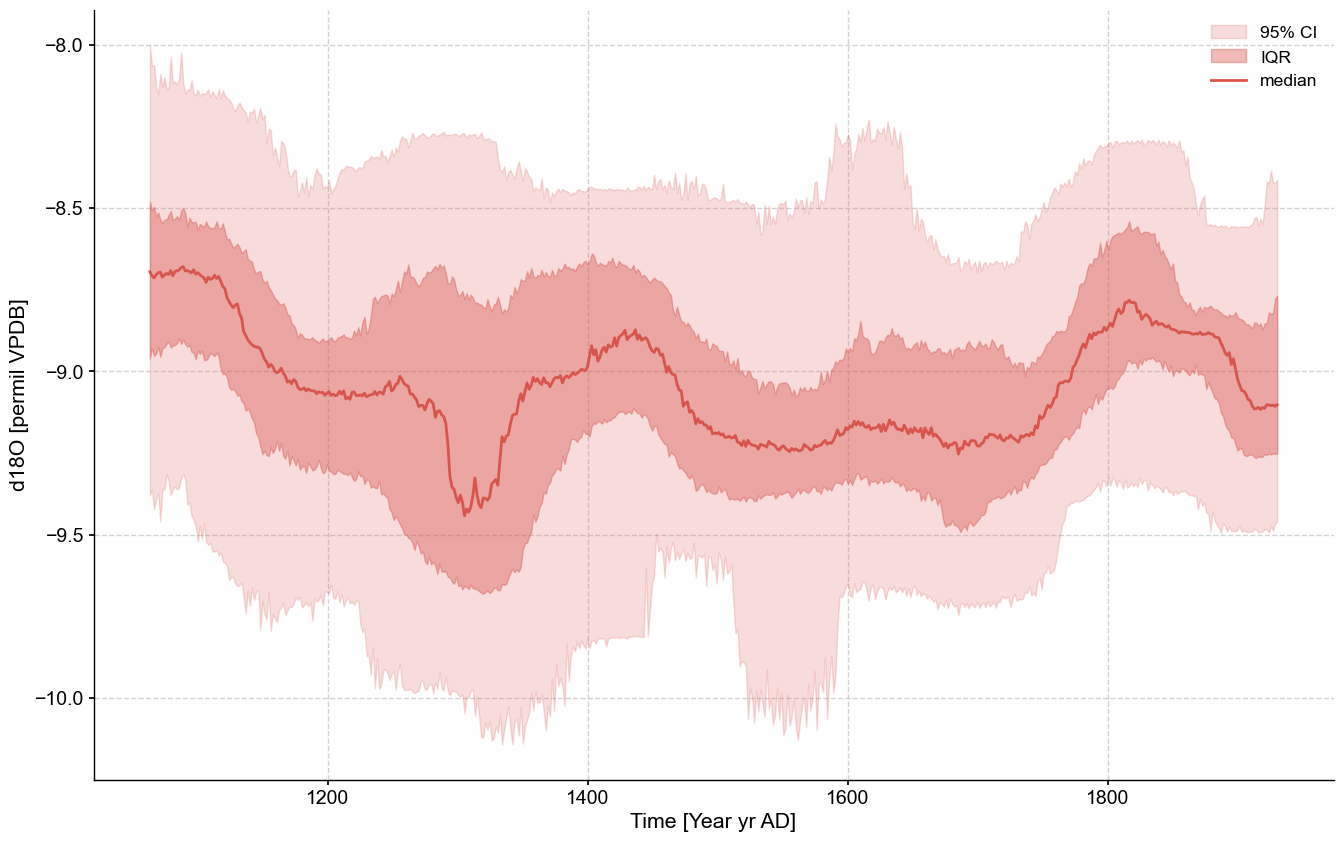

In [8]:
ensemble.common_time().plot_envelope(figsize=(16,10))

##### Exporting ensemble information to `Numpy Arrays` and `Pandas DataFrame`

In some instances, it may be useful to return the age information stored in a LiPD file directly into a [`numpy.array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html) or a [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) for use outside of Pyleoclim. You can do this using the [`to_array`](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.ensembleseries.EnsembleSeries.to_array) and [`to_dataframe`](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.ensembleseries.EnsembleSeries.to_dataframe). 

Let's recover the age ensemble and store them it into a `numpy.array`. The `to_array` function takes the following arguments:                                                            
* axis (str, ['time', 'value'], optional) – Whether the return the ensemble from value or time. The default is ‘value’.
* labels (bool, [True,False], optional) – Whether to retrun a separate list with the timseries labels. The default is True.

In [9]:
vals, headers = ensemble.to_array(axis='time')
vals

array([[2007., 2007., 2008., ..., 2007., 2007., 2007.],
       [2007., 2007., 2008., ..., 2007., 2007., 2007.],
       [2006., 2006., 2008., ..., 2006., 2006., 2006.],
       ...,
       [ 985.,  957.,  896., ..., 1000., 1005.,  655.],
       [ 985.,  957.,  895., ..., 1000., 1004.,  655.],
       [ 985.,  957.,  894., ..., 1000., 1004.,  654.]])

Another option is to return to a `pandas.DataFrame` using the `to_dataframe` method. 

#### Example from NOAA

For this example we'll use the [MD982181](https://www.ncei.noaa.gov/access/paleo-search/study/2634) record from [Khider et al. (2014)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2013PA002534). We will source the CSV file containing the age ensemble for the SST values from this record from the [Linked Earth wiki page](https://wiki.linked.earth/File:MD982181.Khider.2014.chron1model1ensemble.csv), though a local CSV file could also be used here with minimal changes.

In [10]:
#Loading the ensemble tables. Note that column 0 corresponds to depth

ensemble_url = 'https://wiki.linked.earth/wiki/images/7/79/MD982181.Khider.2014.chron1model1ensemble.csv'

ensemble_df = pd.read_csv(ensemble_url,header=None)

ensemble_df

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,1.0,207.301109,-21.273103,359.894201,3.950743,69.791337,195.918556,477.506539,254.071725,18.043039,...,200.832011,29.981959,159.156188,-30.030879,10.998169,256.535747,232.055674,61.422668,-24.770834,475.549540
1,2.5,210.598385,-6.095219,363.537231,19.011842,79.372074,202.387822,478.016110,257.074060,29.545646,...,207.932983,38.840758,167.586782,-18.344618,17.123170,262.956721,235.486451,71.243925,-18.329537,475.748343
2,5.0,216.040623,19.369267,369.630612,44.252513,95.396047,213.157541,478.839723,262.061321,48.814435,...,219.792022,53.661308,181.704918,1.189714,27.295888,273.711759,241.180553,87.665771,-7.626766,476.046104
3,6.5,219.280420,34.728605,373.297041,59.463559,105.037349,219.613424,479.321568,265.045696,60.422642,...,226.919006,62.580463,190.208029,12.937785,33.382424,280.190421,244.585561,97.544358,-1.220809,476.208644
4,7.0,220.356966,39.859076,374.520562,64.542743,108.254684,221.764597,479.480550,266.039429,64.298267,...,229.296199,65.557071,193.046673,16.857451,35.409002,282.353374,245.719046,100.840599,0.912427,476.260687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,827.0,9434.248215,9545.771005,9596.976203,9588.136195,9438.630060,9611.671864,9514.355046,9613.503470,9515.947093,...,9441.197068,9509.291601,9584.105141,9487.163021,9432.573204,9528.250540,9577.714737,9442.864368,9570.410846,9500.091340
333,836.0,9662.543323,9749.147272,9818.449843,9818.782493,9638.010047,9835.377593,9714.793979,9837.351019,9721.120860,...,9644.065902,9728.433304,9795.061924,9676.390919,9623.447075,9734.211473,9803.351304,9649.143650,9780.641448,9718.151948
334,839.0,9739.420208,9817.390937,9892.732202,9896.475674,9705.027332,9910.431322,9781.949176,9912.636525,9790.081021,...,9712.162198,9802.252278,9865.803631,9739.802457,9687.383488,9803.283922,9879.292011,9718.456343,9851.235118,9791.439448
335,843.0,9842.408624,9908.664339,9992.061086,10000.572811,9794.731539,10010.805766,9871.703033,10013.435160,9882.382981,...,9803.252697,9901.159253,9960.389782,9824.560618,9772.826640,9895.641914,9981.000988,9811.218375,9945.682572,9889.530993


The format here is different from the one we encountered from the LiPD file, so we'll do things a bit differently. Outside of LiPD (and sometimes within it), the format of age ensemble tables can vary considerably. We'll show how to approach formatting this table in a minute. First, let's look at the paleo data we're working with.

In [11]:
url = 'https://www.ncei.noaa.gov/pub/data/paleo/contributions_by_author/khider2014/khider2014-sst.txt'


df = pd.read_csv(url, sep = '\t', skiprows=137)

df

,depth_cm,Mg/Ca-g.rub-w,d18Og.rub-w,age_calyrBP,age-2.5%,age-34%,age-68%,age-97.5%,SST,SST-2.5%,SST-34%,SST-68%,SST-97.5%,δ18Osw,δ18Osw 2.5%,δ18Osw 34%,δ18Osw 68%,δ18Osw 97.5%
0,1.0,5.21,-999.990,199,-63,96,237,428,27.80,26.88,27.63,28.04,28.74,-999.99,-999.99,-999.99,-999.99,-999.99
1,2.5,5.04,-2.830,205,-53,104,242,429,27.41,26.47,27.23,27.65,28.35,0.02,-0.32,-0.05,0.10,0.35
2,3.0,-999.99,-2.810,207,-50,107,244,430,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99
3,4.0,-999.99,-2.780,211,-44,112,248,432,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99
4,5.0,5.10,-2.788,216,-38,117,252,433,27.55,26.58,27.36,27.79,28.49,0.09,-0.25,0.01,0.17,0.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,831.0,-999.99,-2.580,9604,9450,9563,9649,9764,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99,-999.99
451,836.0,5.14,-2.650,9722,9565,9677,9770,9886,27.64,26.67,27.46,27.87,28.59,0.01,-0.33,-0.06,0.09,0.34
452,839.0,5.77,-2.620,9793,9634,9747,9844,9960,28.95,28.08,28.77,29.17,29.88,0.30,-0.04,0.23,0.38,0.63
453,843.0,5.45,-2.640,9888,9726,9839,9942,10059,28.30,27.42,28.14,28.53,29.19,0.13,-0.20,0.07,0.22,0.47


The missing value field was `-999`, let's change it to NaN.

In [12]:
df.replace(-999.99, np.NaN, inplace=True)

In [13]:
df

,depth_cm,Mg/Ca-g.rub-w,d18Og.rub-w,age_calyrBP,age-2.5%,age-34%,age-68%,age-97.5%,SST,SST-2.5%,SST-34%,SST-68%,SST-97.5%,δ18Osw,δ18Osw 2.5%,δ18Osw 34%,δ18Osw 68%,δ18Osw 97.5%
0,1.0,5.21,NaN,199,-63,96,237,428,27.80,26.88,27.63,28.04,28.74,NaN,NaN,NaN,NaN,NaN
1,2.5,5.04,-2.830,205,-53,104,242,429,27.41,26.47,27.23,27.65,28.35,0.02,-0.32,-0.05,0.10,0.35
2,3.0,NaN,-2.810,207,-50,107,244,430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,-2.780,211,-44,112,248,432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,5.10,-2.788,216,-38,117,252,433,27.55,26.58,27.36,27.79,28.49,0.09,-0.25,0.01,0.17,0.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,831.0,NaN,-2.580,9604,9450,9563,9649,9764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,836.0,5.14,-2.650,9722,9565,9677,9770,9886,27.64,26.67,27.46,27.87,28.59,0.01,-0.33,-0.06,0.09,0.34
452,839.0,5.77,-2.620,9793,9634,9747,9844,9960,28.95,28.08,28.77,29.17,29.88,0.30,-0.04,0.23,0.38,0.63
453,843.0,5.45,-2.640,9888,9726,9839,9942,10059,28.30,27.42,28.14,28.53,29.19,0.13,-0.20,0.07,0.22,0.47


As in the crystal cave example, loading the data is fairly simple. Most of the legwork is getting our data into the appropriate format. We can pull the necessary paleo data from the NOAA dataframe. Note that we need to check the column names as sometimes unusual syntax will throw a wrench in the works. In this example the `Depth` column is in fact `depth_cm`.

In [14]:
df.columns

Index(['depth_cm', 'Mg/Ca-g.rub-w', 'd18Og.rub-w', 'age_calyrBP', 'age-2.5%',
       'age-34%', 'age-68%', 'age-97.5%', 'SST ', 'SST-2.5%', 'SST-34%',
       'SST-68%', 'SST-97.5%', 'δ18Osw', 'δ18Osw 2.5%', 'δ18Osw 34%',
       'δ18Osw 68%', 'δ18Osw 97.5%'],
      dtype='object')

Let's create a `GeoSeries` instead of a `Series` object to start the `EnsembleGeoSeries` to illustrate the functionality that takes depth from the `GeoSeries` object directly. 

In [15]:
paleoValues = df['SST '].to_numpy().flatten()
paleoDepth = df['depth_cm'].to_numpy().flatten()
age = df['age_calyrBP'].to_numpy().flatten() 

value_name = 'SST'
value_unit = 'deg C'

time_name = 'Age'
time_unit = 'Year BP'

Now for the ensemble values.

In [16]:
ensemble_df

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,1.0,207.301109,-21.273103,359.894201,3.950743,69.791337,195.918556,477.506539,254.071725,18.043039,...,200.832011,29.981959,159.156188,-30.030879,10.998169,256.535747,232.055674,61.422668,-24.770834,475.549540
1,2.5,210.598385,-6.095219,363.537231,19.011842,79.372074,202.387822,478.016110,257.074060,29.545646,...,207.932983,38.840758,167.586782,-18.344618,17.123170,262.956721,235.486451,71.243925,-18.329537,475.748343
2,5.0,216.040623,19.369267,369.630612,44.252513,95.396047,213.157541,478.839723,262.061321,48.814435,...,219.792022,53.661308,181.704918,1.189714,27.295888,273.711759,241.180553,87.665771,-7.626766,476.046104
3,6.5,219.280420,34.728605,373.297041,59.463559,105.037349,219.613424,479.321568,265.045696,60.422642,...,226.919006,62.580463,190.208029,12.937785,33.382424,280.190421,244.585561,97.544358,-1.220809,476.208644
4,7.0,220.356966,39.859076,374.520562,64.542743,108.254684,221.764597,479.480550,266.039429,64.298267,...,229.296199,65.557071,193.046673,16.857451,35.409002,282.353374,245.719046,100.840599,0.912427,476.260687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,827.0,9434.248215,9545.771005,9596.976203,9588.136195,9438.630060,9611.671864,9514.355046,9613.503470,9515.947093,...,9441.197068,9509.291601,9584.105141,9487.163021,9432.573204,9528.250540,9577.714737,9442.864368,9570.410846,9500.091340
333,836.0,9662.543323,9749.147272,9818.449843,9818.782493,9638.010047,9835.377593,9714.793979,9837.351019,9721.120860,...,9644.065902,9728.433304,9795.061924,9676.390919,9623.447075,9734.211473,9803.351304,9649.143650,9780.641448,9718.151948
334,839.0,9739.420208,9817.390937,9892.732202,9896.475674,9705.027332,9910.431322,9781.949176,9912.636525,9790.081021,...,9712.162198,9802.252278,9865.803631,9739.802457,9687.383488,9803.283922,9879.292011,9718.456343,9851.235118,9791.439448
335,843.0,9842.408624,9908.664339,9992.061086,10000.572811,9794.731539,10010.805766,9871.703033,10013.435160,9882.382981,...,9803.252697,9901.159253,9960.389782,9824.560618,9772.826640,9895.641914,9981.000988,9811.218375,9945.682572,9889.530993


In [17]:
chronDepth = ensemble_df[0].to_numpy() #The depth values in this case are stored in column 0

chronValues = ensemble_df[ensemble_df.columns.values[1:]].to_numpy() 

Checking that our dimensions are as we expect:

In [18]:
print(f'Num rows in chronValues: {chronValues.shape[0]}, Length of chronDepth: {len(chronDepth)}')

Num rows in chronValues: 337, Length of chronDepth: 337


Let's create an `EnsembleGeoSeries` object for a `GeoSeries` object. The main advantage of doing so is to deal with NaNs in the timeseries. Upon creation of the `GeoSeries` object the time, depth, and value axes are aligned without missing values; ensuring consistency among these vectors for the creation of the `EnsembleGeoSeries` object:

In [19]:
ts = pyleo.GeoSeries(time = age, value = paleoValues, value_name = value_name, verbose=False,
                  time_name = time_name, value_unit = value_unit, time_unit = time_unit, depth = paleoDepth, lat = 6.45, lon = 125.83)

ensemble = pyleo.EnsembleGeoSeries.from_AgeEnsembleArray(geo_series = ts, age_array = chronValues,
                                                     age_depth = chronDepth, verbose = False)

And again we can leverage Pyleoclim's ensemble capabilities!

(<Figure size 1600x1000 with 1 Axes>,
 <Axes: xlabel='Age [Year BP]', ylabel='SST [deg C]'>)

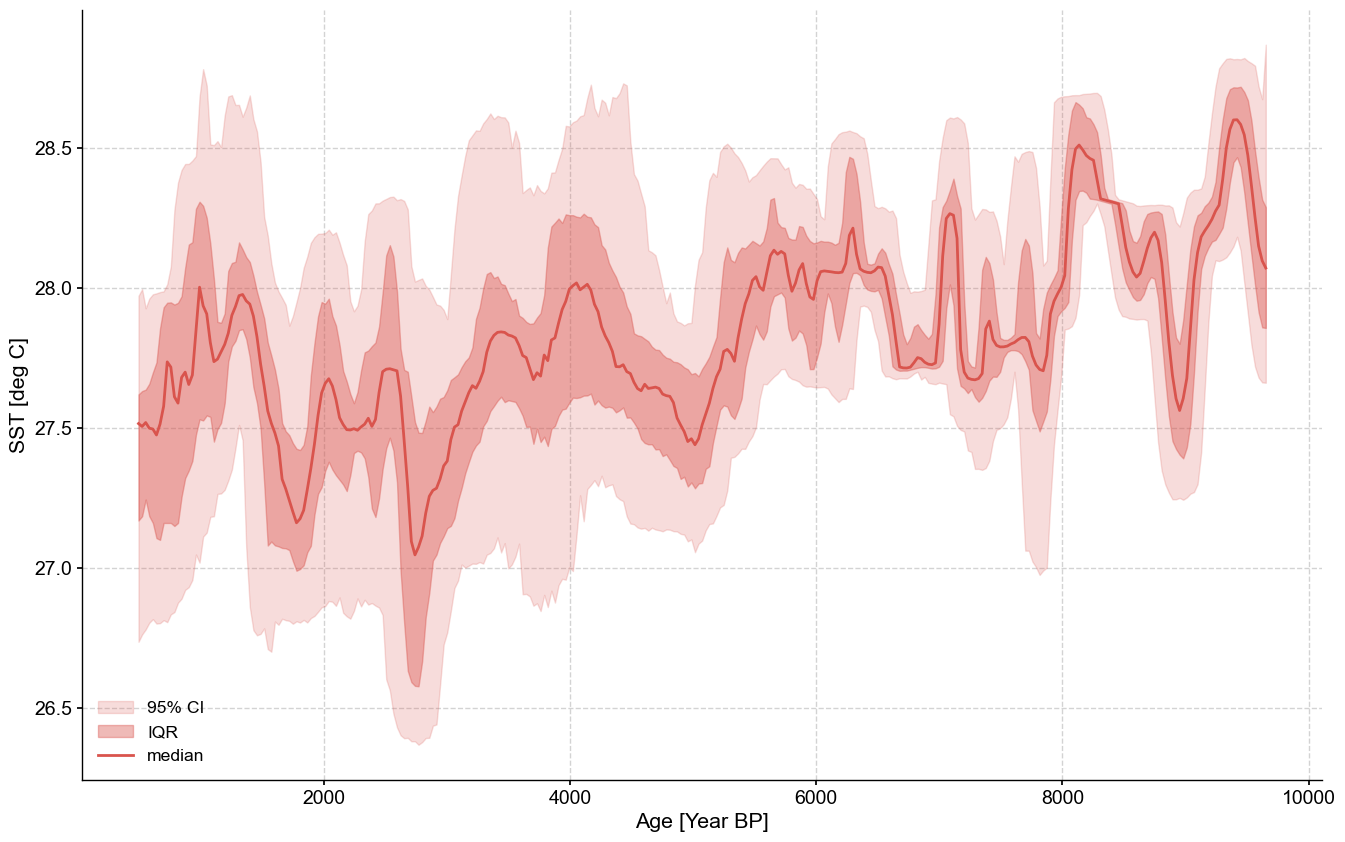

In [20]:
ensemble.common_time().plot_envelope(figsize=(16,10))

## Ensemble series from paleo ensemble

In the following example we'll create an `EnsembleGeoSeries` object where uncertainty is represented by variations in the value axis. This structure is more typically used to represent measurement uncertainty, though depending on the age modeling method used it can also be used to represent dating uncertainty.

In order to do this we will use the `from_PaleoEnsembleArray` method attached to the `EnsembleGeoSeries` class. Note that this method is also available from the `EnsembleSeries` class.


In order to get at a paleo based ensemble table we'll create a custom PyLiPD query. If you want to learn more about how to construct these queries for yourself, we recommend checking out the [PyLiPD Tutorials](http://linked.earth/pylipdTutorials/notebooks/L2_custom_queries.html).

In [21]:
D = LiPD()

D.load(['../data/MD982181.Khider.2014.lpd'])

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

Loaded..


In [22]:
query = """
    PREFIX le: <http://linked.earth/ontology#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT ?datasetName ?ensembleTable ?ensembleVariableName ?ensembleVariableValues ?ensembleVariableUnits ?ensembleDepthName ?ensembleDepthValues ?ensembleDepthUnits ?notes ?methodobj ?methods
    WHERE {
        ?ds a le:Dataset .
        ?ds le:hasName ?datasetName .
            FILTER regex(?datasetName, "[dsname].*", "i").

        ?ds le:hasPaleoData ?paleo .
        ?paleo le:modeledBy ?model .
        ?model le:hasEnsembleTable ?ensembleTable .
            OPTIONAL{?ensembleTable le:notes ?notes .}

        ?ensembleTable le:hasVariable ?ensvar .
        ?ensvar le:hasName ?ensembleVariableName .
            FILTER regex(lcase(?ensembleVariableName), "[ensembleVarName].*", "i").
        ?ensvar le:hasValues ?ensembleVariableValues .
        OPTIONAL{?ensvar le:hasUnits ?ensembleVariableUnitsObj .
                ?ensembleVariableUnitsObj rdfs:label ?ensembleVariableUnits .
                VALUES ?ensembleVariableUnits {"deg C"} .}

        ?ensembleTable le:hasVariable ?ensdepthvar .
        ?ensdepthvar le:hasName ?ensembleDepthName .
            FILTER regex(lcase(?ensembleDepthName), "[ensembleDepthVarName].*", "i").
            FILTER (?ensembleDepthName = 'depth')
        ?ensdepthvar le:hasValues ?ensembleDepthValues .
            OPTIONAL{?ensdepthvar le:hasUnits ?ensembleDepthUnitsObj .
                    ?ensembleDepthUnitsObj rdfs:label ?ensembleDepthUnits.}
    
       }
"""

_,ens_df = D.query(query)

ens_df

,datasetName,ensembleTable,ensembleVariableName,ensembleVariableValues,ensembleVariableUnits,ensembleDepthName,ensembleDepthValues,ensembleDepthUnits,notes,methodobj,methods
0,MD982181.Khider.2014,http://linked.earth/lipd/paleo0model0ensemble0,realization 1,"[[1.0, 28.2528873873423, 27.6829378220138, 28....",deg C,depth,"[1.0, 2.5, 5.0, 6.5, 7.0, 8.0, 11.5, 13.0, 15....",cm,SST ensemble from the Bayesian calibration des...,None,None
1,MD982181.Khider.2014,http://linked.earth/lipd/paleo0model0ensemble0,depth,"[1.0, 2.5, 5.0, 6.5, 7.0, 8.0, 11.5, 13.0, 15....",None,depth,"[1.0, 2.5, 5.0, 6.5, 7.0, 8.0, 11.5, 13.0, 15....",cm,SST ensemble from the Bayesian calibration des...,None,None
2,MD982181.Khider.2014,http://linked.earth/lipd/paleo0model1ensemble0,realization 1,"[[2.5, -0.1929763844799, -0.266404906905685, 0...",None,depth,"[2.5, 5.0, 6.5, 7.0, 8.0, 11.5, 13.0, 15.0, 16...",cm,d18Osw ensemble from the Bayesian calibration ...,None,None
3,MD982181.Khider.2014,http://linked.earth/lipd/paleo0model1ensemble0,depth,"[2.5, 5.0, 6.5, 7.0, 8.0, 11.5, 13.0, 15.0, 16...",None,depth,"[2.5, 5.0, 6.5, 7.0, 8.0, 11.5, 13.0, 15.0, 16...",cm,d18Osw ensemble from the Bayesian calibration ...,None,None


Having returned a reasonable looking dataframe, we'll pull the data we need. We have to apply some transformations to the data in order to get them into proper array format since LiPD stores data as strings. Built in PyLiPD functions take care of this for you, we only have to worry about it because we're using a custom query.

Everything else we do after this is almost identical to our other examples, the only difference being that `paleoValues` is now a matrix and `chronValues` is a vector.

In [23]:
ens_df['ensembleVariableValues'] = ens_df['ensembleVariableValues'].apply(lambda row : np.array(ast.literal_eval(row)))
ens_df['ensembleDepthValues'] = ens_df['ensembleDepthValues'].apply(lambda row : np.array(ast.literal_eval(row)))

In [24]:
paleo_df = D.get_timeseries_essentials()
paleo_row = paleo_df[paleo_df['paleoData_variableName']=='sst']
paleo_row

,dataSetName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,time_variableName,time_values,time_units,depth_variableName,depth_values,depth_units
6,MD982181.Khider.2014,Marine sediment,6.45,125.83,-2114.0,sst,"[27.8, 27.41, nan, nan, 27.55, 27.16, 27.35, 2...",deg C,None,None,age_calyrbp,"[199.0, 205.0, 207.0, 211.0, 216.0, 222.0, 224...",yr BP,depth_cm,"[1.0, 2.5, 3.0, 4.0, 5.0, 6.5, 7.0, 8.0, 9.0, ...",cm


In [25]:
paleoValues = ens_df[ens_df['ensembleVariableUnits']=='deg C']['ensembleVariableValues'].to_numpy()[0] #Drop the column that contains depth
paleoDepth = ens_df[ens_df['ensembleVariableUnits']=='deg C']['ensembleDepthValues'].to_numpy()[0]

value_name = "SST"
value_unit = "deg C"

chronValues = paleo_row['time_values'].to_numpy()[0]
chronDepth = paleo_row['depth_values'].to_numpy()[0]

time_name = 'Time'
time_unit = 'Years BP'

Let's create a `GeoSeries` object as the basis for our `EnsembleGeoSeries` object:

In [26]:
ts = pyleo.GeoSeries(time = chronValues, value = paleo_row['paleoData_values'].iloc[0], 
                     time_name =  time_name, time_unit = time_unit, verbose=False,
                     value_name = value_name, value_unit = value_unit,
                     label = 'MD98-2181', archiveType = 'Marine sediment',
                     depth = chronDepth, depth_name = 'Depth', depth_unit = 'cm', lat = paleo_df['geo_meanLat'].iloc[0],
                    lon = paleo_df['geo_meanLon'].iloc[0])

ensemble = pyleo.EnsembleGeoSeries.from_PaleoEnsembleArray(geo_series = ts, paleo_array = paleoValues, age_depth = ts.depth, paleo_depth = paleoDepth)

We can then apply ensemble methods, per usual.

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:05<00:00, 178.28it/s]


(<Figure size 1600x1000 with 1 Axes>,
 <Axes: xlabel='Period [Years BP]', ylabel='PSD'>)

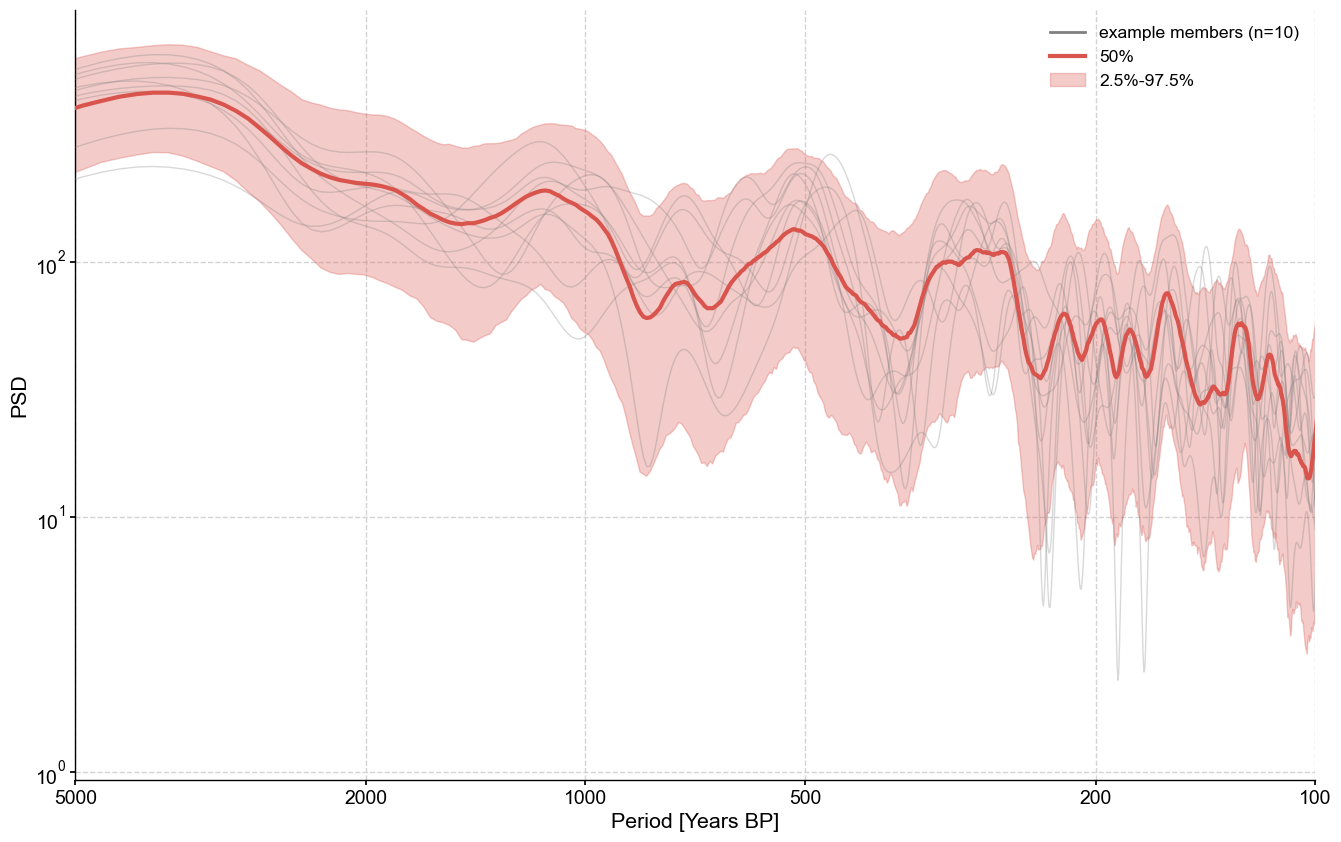

In [27]:
ensemble.common_time().spectral().plot_envelope(figsize=(16,10))

In [28]:
%watermark -n -u -v -iv -wpy

Last updated: Mon Aug 26 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.24.0

y: not installed

pyleoclim: 1.0.0b0
numpy    : 1.26.4
pandas   : 2.1.4

Watermark: 2.4.3

